1. Unzipping the images

In [53]:
# !unzip chicken.zip
# !unzip duck.zip

In [54]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import imghdr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2. Creating a dataset with these images and labelling them.

In [55]:
chicken_dir = os.path.join('./', 'chicken')
duck_dir = os.path.join('./', 'duck')

images = []
labels = []

allowed_extensions = ['jpg', 'jpeg', 'png', 'bmp', 'gif']

for filename in os.listdir(chicken_dir):
    ext = imghdr.what(os.path.join(chicken_dir, filename))
    if ext in allowed_extensions:
        img_path = os.path.join(chicken_dir, filename)
        img = Image.open(img_path)
        img_arr = np.array(img)
        images.append(img_arr)
        labels.append(0)

for filename in os.listdir(duck_dir):
    ext = imghdr.what(os.path.join(duck_dir, filename))
    if ext in allowed_extensions:
        img_path = os.path.join(duck_dir, filename)
        img = Image.open(img_path)
        img_arr = np.array(img)
        images.append(img_arr)
        labels.append(1)

df = pd.DataFrame({'images': images, 'label': labels})

3. Train-test split and normalizing the dataset.

In [57]:
X = np.array([np.array(img) for img in df['images']])
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0

4. Importing a basemodel, imagenet and adding custom layers.

In [67]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

5. Training the model.

In [69]:
fitted_model = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])

Epoch 1/100
5/5 [==============================] - 3s 297ms/step - loss: 1.8357 - accuracy: 0.5375 - val_loss: 0.7978 - val_accuracy: 0.5250
Epoch 2/100
5/5 [==============================] - 1s 243ms/step - loss: 0.6406 - accuracy: 0.6500 - val_loss: 0.4526 - val_accuracy: 0.8000
Epoch 3/100
5/5 [==============================] - 1s 242ms/step - loss: 0.3484 - accuracy: 0.8500 - val_loss: 0.3078 - val_accuracy: 0.8750
Epoch 4/100
5/5 [==============================] - 1s 240ms/step - loss: 0.2238 - accuracy: 0.9000 - val_loss: 0.6019 - val_accuracy: 0.6750
Epoch 5/100
5/5 [==============================] - 1s 225ms/step - loss: 0.1492 - accuracy: 0.9375 - val_loss: 0.2602 - val_accuracy: 0.8500
Epoch 6/100
5/5 [==============================] - 1s 243ms/step - loss: 0.0650 - accuracy: 0.9812 - val_loss: 0.2262 - val_accuracy: 0.9250
Epoch 7/100
5/5 [==============================] - 1s 249ms/step - loss: 0.0415 - accuracy: 0.9875 - val_loss: 0.1547 - val_accuracy: 0.9500
Epoch 8/100
5

6. Plotting the loss and accuracy

<Axes: >

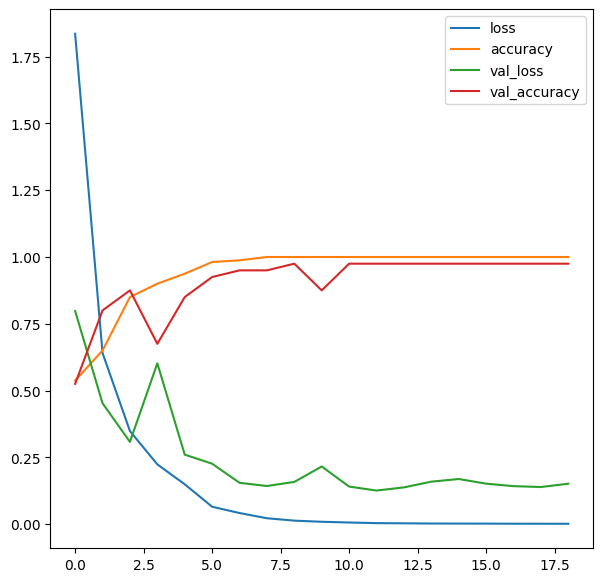

In [70]:
pd.DataFrame(fitted_model.history).plot(figsize = (7,7))

7. Classification Report

In [71]:
y_pred = np.round(model.predict(X_test))
print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 173ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

